In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 05 Aug 2018

Distributed under the terms of the MIT License.

# Notebook to analyse all enzymes used in ZIF-8 experiments using BRENDA database

TODO:
- add license
- modifications
    - introduce exposure consideration
        - get another method for calculating exposure without structure?
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
import pandas as pd
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport BRENDA_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid
%aimport DB_functions
%aimport CHEBI_IO
%aimport BKMS_IO
%aimport KEGG_IO
%aimport Uniprot_IO
%aimport PUBCHEM_IO
%aimport rxn_syst

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [5]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 1_11_1_5__BRENDA_sequences.fasta
-- 1_11_1_6__BRENDA_sequences.fasta
-- 1_11_1_7__BRENDA_sequences.fasta
-- 1_13_12_4__BRENDA_sequences.fasta
-- 1_1_3_4__BRENDA_sequences.fasta
-- 1_1_5_2__BRENDA_sequences.fasta
-- 1_9_3_1__BRENDA_sequences.fasta
-- 3_1_1_3__BRENDA_sequences.fasta
-- 3_1_1_6__BRENDA_sequences.fasta
-- 3_2_1_26__BRENDA_sequences.fasta
-- 3_5_1_11__BRENDA_sequences.fasta
-- 3_5_1_5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)False


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
--- finished 2220 sequences in 0.69 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
--- finished 22068 sequences in 7.67 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
--- finished 16288 sequences in 4.23 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_13_12_4__BRENDA_sequences.fasta
--- finished 379 sequences in 0.12 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_3_4__BRENDA_sequences.fasta
--- finished 36 sequences in 0.02 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_5_2__BRENDA_sequences.fasta
--- finished 1765 sequences in 0.67 seconds ---
plot d

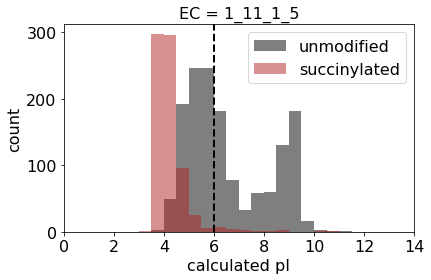

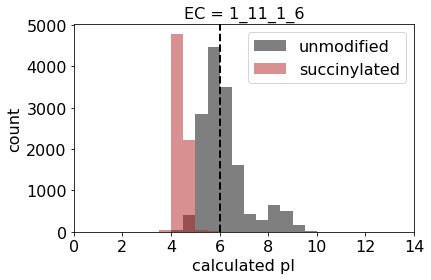

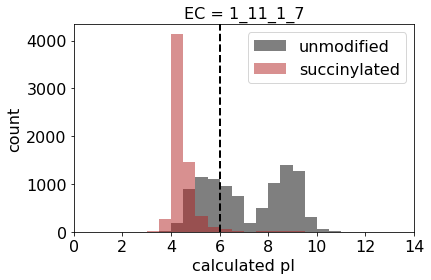

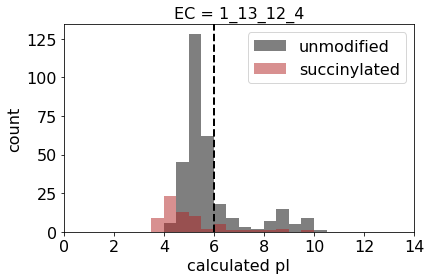

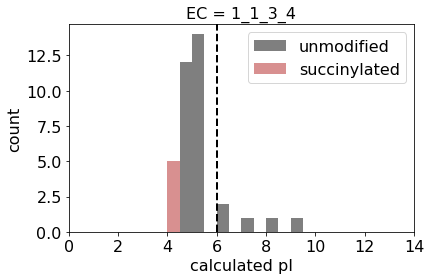

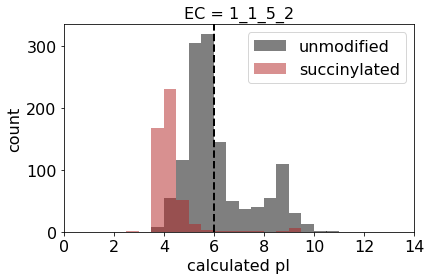

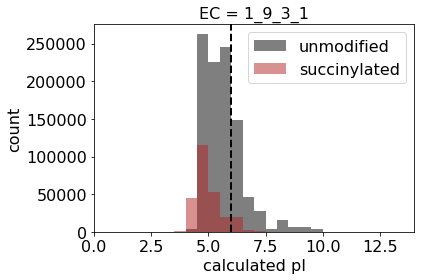

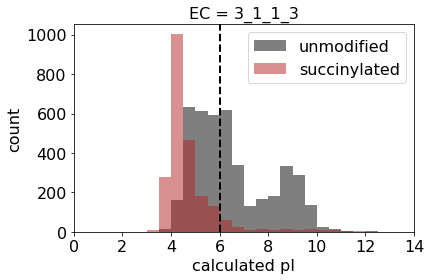

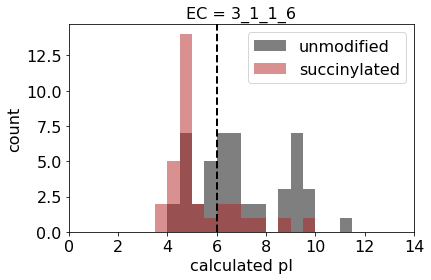

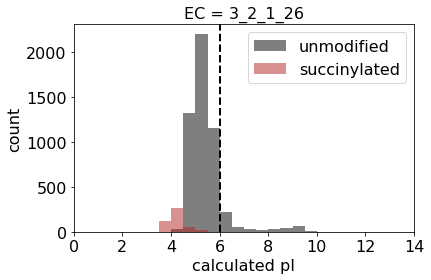

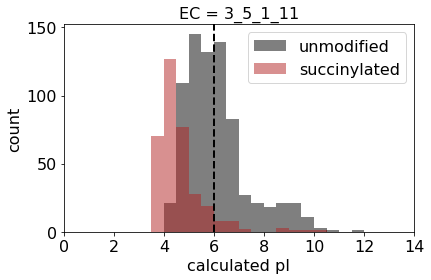

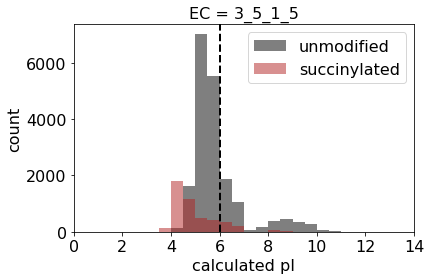

In [9]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

# Collect pI of species used in Literature data base using BRENDA

In [11]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [12]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [13]:
# read in pI output file
pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)

In [14]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific - although the code can be reused
    # get species of interest from known EC records
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        # is species in sequence data?
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        # get pI from BRENDA
        prop_of_int = 'PI'
        list_of_int = br_data[prop_of_int]
        # get list of protein codes with property of interest
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop_of_int, 'in BRENDA')
            values = [list_of_int[i].split(" ")[1] 
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            # apply property specific rules
            # check for ranges - append min and max
            values_min = [i.split('-')[0] for i in values if '-' in i and i[0] != '-']
            values_max = [i.split('-')[1] for i in values if '-' in i and i[0] != '-']
            if len(values_min) > 0 and len(values_max) > 0:
                for i in np.arange(len(values)-1, -1, -1):
                    if '-' in values[i]:
                        del values[i]
                print(values_min, values_max)
                values.append(values_min[0])
                values.append(values_max[0])
            # PI == float
            values = [float(i) for i in values]
            # PI => between 0 and 14
            values = [i for i in values if i >= 0 and i <= 14]
            if len(values) > 0:
                value_of_int[PR] = values
        print('reported pIs in BRENDA:', value_of_int.values())
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

Screen all Enzymes in EC Classes using BRENDA data
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
---  1459 proteins out of 2220 remain, OR 65 % ---
EC: 1.11.1.5
species: equus caballus
species in sequence data: False
species in BRENDA data: False
reported pIs in BRENDA: dict_values([])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
---  14865 proteins out of 22068 remain, OR 67 % ---
EC: 1.11.1.6
species: bos taurus
species in sequence data: True
species in BRENDA data: True
protein code: 12 has PI in BRENDA
protein code: 138 does not have PI in BRENDA
reported pIs in BRENDA: dict_values([[5.4]])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
---  9633 proteins out of 16288 remain, OR 59 % ---
EC: 1.11.1.7
species: armoracia rus

# From the list of reactions reported in the literature - determine, which molecules fit in ZIF-8

In [3]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_mol_set = {
    # EC : species list : unique molecules
    '1.11.1.5': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
    ]},
    '1.11.1.6': {'bos taurus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('3-amino-1,2,4-triazole', 'C1=NNC(=N1)N'),
    ]},
    '1.11.1.7': {'armoracia rusticana': [
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
    ]},
    '1.9.3.1': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
        ('Amplex Red', 'CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O'),
        ('resorufin', 'C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2'),
        ('methyl ethyl ketone peroxide', 'CCC(C)(OO)OOC(C)(CC)OO'),
        ('tert-butyl hydroperoxide', 'CC(C)(C)OO'),
    ]},
    '1.1.5.2': {'none': [
        ('methosulfate', 'COS(=O)(=O)[O-]'),
        ('5-Methylphenazin-5-ium', 'C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31'),
        ('2,6-dichloroindophenol', 'C1=CC(=O)C=CC1=NC2=CC(=C(C(=C2)Cl)O)Cl'),
    ]},
    '3.5.1.5': {'canavalia ensiformis': [
        ('Urea', 'C(=O)(N)N'),
        ('water', 'O'),
        ('carbon dioxide', 'C(=O)=O'),
        ('ammonia', 'N'),
    ]},
    '1.1.3.4': {'aspergillus niger': [
        ('D-glucose (chain)', 'C(C(C(C(C(C=O)O)O)O)O)O'),
        ('D-glucose (ring)', 'C(C1C(C(C(C(O1)O)O)O)O)O'),
        ('gluconic acid', 'C(C(C(C(C(C(=O)O)O)O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('Gluconolactone', 'C(C1C(C(C(C(=O)O1)O)O)O)O'),
    ]},
    '1.13.12.4': {'none': [
        ('hydrogen peroxide', 'OO'),
        ('pyruvate', 'CC(=O)C(=O)[O-]'),
        ('L-lactate', 'CC(C(=O)[O-])[O-]'),
        
    ]},
    '3.2.1.26': {'none': [
        ('sucrose', 'C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O'),
        ('L-fructose', 'C(C(C(C(C(=O)CO)O)O)O)O'),
        ('D-fructose', 'C1C(C(C(C(O1)(CO)O)O)O)O'),
    ]},
    '3.1.1.3': {'thermomyces lanuginosus': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'alcaligenes sp.': [  # not sure about this one - the kinetic resolution may not belong to this enyzme?
                    ('2-octanol', 'CCCCCCC(C)O'),
                    ('vinyl acetate', 'CC(=O)OC=C'),
                    ('octyl acetate', 'CCCCCCCCOC(=O)C'),
                    ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('octanoic acid', 'CCCCCCCC(=O)O'),
                ],
                'pseudomonas fluorescens': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'rhizomucor miehei': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ], 
                'candida antarctica': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'aspergillus niger': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('acetic acid', 'CC(=O)O'),
                ]},
    '3.1.1.6': {'lactobacillus acidophilus': [
        ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
        ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
        ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('acetic acid', 'CC(=O)O'),
        ('p-nitrophenyl phosphate', 'C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)O'),
        ('phosphate acid', 'OP(=O)([O-])[O-]'),
        ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('butyric acid', 'CCCC(=O)O'),
        ('p-nitrophenyl hexanoate', 'CCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('hexanoic acid', 'CCCCCC(=O)O'),
        ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('octanoic acid', 'CCCCCCCC(=O)O'),
        ('p-nitrophenyl decanoate', 'CCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('decanoic acid', 'CCCCCCCCCC(=O)O'),
        ('p-nitrophenyl dodecanoate', 'CCCCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('dodecanoic acid', 'CCCCCCCCCCCC(=O)O'),
    ]},
    '3.5.1.11': {'none': [
        ('penicillin-G', 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C'),
    ]},
    }

In [5]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
# input parameters
database_directory = '/home/atarzia/psp/screening_results/biomin_known/'
output_dir = database_directory

In [6]:
# get all unique molecules and draw 2D structures
molecules = {}
diameters = {}
for i in EC_mol_set.keys():
    for j in EC_mol_set[i].keys():
        for mol in EC_mol_set[i][j]:
            molecules[mol[0]] = mol[1]
            diameters[mol[0]] = 0
            rdkit_functions.draw_smiles_to_svg(mol[1], output_dir+mol[0].replace(' ', '_')+'_2d.svg')

#### calculate size

In [8]:
rdkit_functions.calc_molecule_diameters(molecules,
                                        out_dir=output_dir, vdwScale=0.8, boxMargin=4.0,
                                        spacing=0.6, show_vdw=False, plot_ellip=False,
                                        N_conformers=50, MW_thresh=2000)

molecule: hydrogen peroxide : SMILES: OO
1 out of 46 done
molecule: pyrogallol : SMILES: C1=CC(=C(C(=C1)O)O)O
2 out of 46 done
molecule: purporogallin : SMILES: C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O
3 out of 46 done
molecule: water : SMILES: O
4 out of 46 done
molecule: oxygen : SMILES: O=O
5 out of 46 done
molecule: 3-amino-1,2,4-triazole : SMILES: C1=NNC(=N1)N
6 out of 46 done
molecule: ABTS : SMILES: CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC
7 out of 46 done
molecule: Amplex Red : SMILES: CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O
8 out of 46 done
molecule: resorufin : SMILES: C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2
9 out of 46 done
molecule: methyl ethyl ketone peroxide : SMILES: CCC(C)(OO)OOC(C)(CC)OO
10 out of 46 done
molecule: tert-butyl hydroperoxide : SMILES: CC(C)(C)OO
11 out of 46 done
molecule: methosulfate : SMILES: COS(=O)(=O)[O-]
12 out of 46 done
molecule: 5-Methylphenazin-5-ium : SMILES: C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31
13 out of 46 done
molecu

#### get results

In [9]:
threshold = float(param_dict['diffuse_threshold'])
diffuse = {}
no_diffuse = {}
count = 0
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    count += 1
    results = pd.read_csv(out_file)
    min_diam = min(results['diam1'])
    mid_diam = min(results['diam2'])
    # print(min(results['diam1']))
    # print(min(results['diam2']))
    # plt.hist(results['diam1'], facecolor='k', alpha=0.4)
    # plt.hist(results['diam2'], facecolor='r', alpha=0.4)
    if mid_diam <= threshold:
        print(name+':')
        print('can diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        diffuse[name] = smile
    else:
        print(name+':')
        print('cannot diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        no_diffuse[name] = smile
    print('-')
print('analyzed ', count, 'molecules')

hydrogen peroxide:
can diffuse
min diameter = 2.767 angstrom
mid diameter = 3.16 angstrom
-
pyrogallol:
cannot diffuse
min diameter = 3.097 angstrom
mid diameter = 7.058 angstrom
-
purporogallin:
cannot diffuse
min diameter = 3.943 angstrom
mid diameter = 8.733 angstrom
-
water:
can diffuse
min diameter = 2.492 angstrom
mid diameter = 2.586 angstrom
-
oxygen:
can diffuse
min diameter = 2.841 angstrom
mid diameter = 2.9 angstrom
-
3-amino-1,2,4-triazole:
cannot diffuse
min diameter = 3.009 angstrom
mid diameter = 5.274 angstrom
-
ABTS:
cannot diffuse
min diameter = 6.273 angstrom
mid diameter = 9.03 angstrom
-
Amplex Red:
cannot diffuse
min diameter = 5.2 angstrom
mid diameter = 10.211 angstrom
-
resorufin:
cannot diffuse
min diameter = 3.366 angstrom
mid diameter = 7.069 angstrom
-
methyl ethyl ketone peroxide:
cannot diffuse
min diameter = 5.667 angstrom
mid diameter = 6.93 angstrom
-
tert-butyl hydroperoxide:
cannot diffuse
min diameter = 5.344 angstrom
mid diameter = 5.69 angstrom
-

#### Plot categorical scatter plot

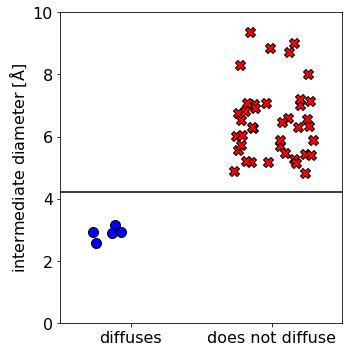

In [10]:
threshold = float(param_dict['diffuse_threshold'])
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.axhline(y=threshold, c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

#### Plot shapes

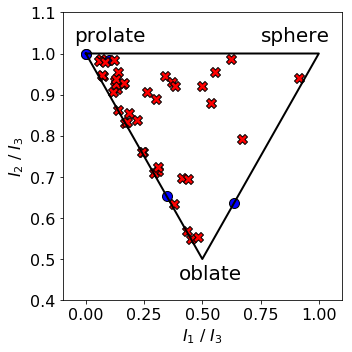

In [11]:
threshold = float(param_dict['diffuse_threshold'])
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(np.average(results['ratio_1']),
               np.average(results['ratio_2']),
               c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax.text(0.75, 1.03, 'sphere', fontsize=20)
ax.text(0.4, 0.45, 'oblate', fontsize=20)
ax.text(-0.05, 1.03, 'prolate', fontsize=20)
define_parity_plot_variables(ax,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig.tight_layout()
fig.savefig(output_dir+"shape.pdf", dpi=720,
            bbox_inches='tight')

# Collect reactant-product systems 
suggest new reactions!

### Collect all reaction systems from multiple databases
Online.

In [12]:
# set output directory
output_dir = '/home/atarzia/psp/screening_results/biomin_search/'

# set databases to search to collect reaction systems
# BKMS should always be last as the culmination of all DBs
Databases = ['BRENDA', 'SABIO', 'KEGG', 'BKMS', ]

# set EC numbers of interest
EC_int = ['1.11.1.5', '1.11.1.6', '1.11.1.7', '1.9.3.1',
          '1.1.5.2', '3.5.1.5', '1.1.3.4', '1.13.12.4',
          '3.2.1.26', '3.1.1.3', '3.1.1.6', '3.5.1.11']

# csv file with molecular output
mol_output_file = output_dir+'screening_output.csv'
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [13]:
for DB in Databases:
    # get database specific information
    DB_prop = DB_functions.get_DB_prop(DB)
    db_dir = DB_prop[0]
    # iterate over EC numbers of interest
    for EC in EC_int:
        rxn_syst.get_reaction_systems(EC, DB, output_dir, clean_system=True)

DB: BRENDA - EC: 1.11.1.5 - DB ID: BR1 - 0 of 43
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR2 - 1 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR3 - 2 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR4 - 3 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR5 - 4 of 43
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR6 - 5 of 43
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR7 - 6 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR8 - 7 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR9 - 8 of 4

RDKit WARNING: [18:44:41]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR2 - 1 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR3 - 2 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR4 - 3 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR5 - 4 of 42
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR6 - 5 of 42
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR7 - 6 of 42
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR8 - 7 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR9 - 8 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR10 - 9 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR11 - 10 of 42
skip

RDKit WARNING: [18:44:49]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR32 - 31 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR33 - 32 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR34 - 33 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR35 - 34 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR36 - 35 of 42


RDKit WARNING: [18:44:51]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR37 - 36 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR38 - 37 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR39 - 38 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR40 - 39 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR41 - 40 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR42 - 41 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR1 - 0 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR2 - 1 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR3 - 2 of 270
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR4 - 3

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR108 - 107 of 270
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR109 - 108 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR110 - 109 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR111 - 110 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR112 - 111 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR113 - 112 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR114 - 113 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR115 - 114 of 270
skip? True
-

no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR203 - 202 of 270
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR204 - 203 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR205 - 204 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR206 - 205 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR207 - 206 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR208 - 207 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR209 - 208 of 270
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR210 - 209 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR211 - 210 of 270

no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR9 - 8 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR10 - 9 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR11 - 10 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR12 - 11 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR13 - 12 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR14 - 13 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR15 - 14 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR16 - 15 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR17 - 16 of 55
no match in DB
search PUBCHEM
no match i

RDKit WARNING: [18:49:14]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR44 - 43 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR45 - 44 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR46 - 45 of 55


RDKit WARNING: [18:49:21]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR47 - 46 of 55


RDKit WARNING: [18:49:25]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR48 - 47 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR49 - 48 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR50 - 49 of 55
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR51 - 50 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR52 - 51 of 55


RDKit WARNING: [18:49:47]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR53 - 52 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR54 - 53 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR55 - 54 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR1 - 0 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR2 - 1 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR3 - 2 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR4 - 3 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR5 - 4 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR6 - 5 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 

RDKit ERROR: [18:51:09]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [18:51:09]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR35 - 34 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR36 - 35 of 128
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR37 - 36 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR38 - 37 of 128
no match in DB
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR39 - 38 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR40 - 39 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: 

RDKit ERROR: [18:51:36]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [18:51:37]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR47 - 46 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
structure could not be deciphered
probably a polymeric structure - skipping.


RDKit ERROR: [18:51:41]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [18:51:42]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR48 - 47 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
structure could not be deciphered
probably a polymeric structure - skipping.


RDKit ERROR: [18:51:46]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [18:51:47]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR49 - 48 of 128
no match in DB
search PUBCHEM


RDKit ERROR: [18:51:52]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [18:51:52]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR50 - 49 of 128
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR51 - 50 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR52 - 51 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR53 - 52 of 128
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR54 - 53 of 128
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR55 - 54 of 128
skip? True
------------------------------

no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR123 - 122 of 128
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR124 - 123 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
structure could not be deciphered
probably a polymeric structure - skipping.


RDKit ERROR: [18:54:42]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [18:54:43]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR125 - 124 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR126 - 125 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR127 - 126 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR128 - 127 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR1 - 0 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR2 - 1 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR3 - 2 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR4 - 3 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR5 - 4 of 10
no match in DB
search PUBCHEM
molecule does

RDKit WARNING: [18:55:08]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR5 - 4 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR6 - 5 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR7 - 6 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR8 - 7 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR9 - 8 of 76


RDKit WARNING: [18:55:16]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR10 - 9 of 76


RDKit WARNING: [18:55:18]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR11 - 10 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR12 - 11 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR13 - 12 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR14 - 13 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR15 - 14 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR16 - 15 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR17 - 16 of 76
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR18 - 17 of 76


RDKit WARNING: [18:55:25]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR19 - 18 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR20 - 19 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR21 - 20 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR22 - 21 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR23 - 22 of 76


RDKit WARNING: [18:55:45]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR24 - 23 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM


RDKit WARNING: [18:55:54]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR25 - 24 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM


RDKit WARNING: [18:56:02]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR26 - 25 of 76
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR27 - 26 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR28 - 27 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR29 - 28 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR30 - 29 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR31 - 30 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR32 - 31 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR33 - 32 of 76
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR34 - 33 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
------------------------

RDKit WARNING: [18:56:46]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR46 - 45 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR47 - 46 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR48 - 47 of 76


RDKit WARNING: [18:56:48]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR49 - 48 of 76
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [18:56:53]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR50 - 49 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR51 - 50 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR52 - 51 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR53 - 52 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR54 - 53 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR55 - 54 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR56 - 55 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR57 - 56 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR58 - 57 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR59 - 58 of 76
no match in DB
search PUBCHEM

RDKit WARNING: [18:57:01]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR60 - 59 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR61 - 60 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR62 - 61 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR63 - 62 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR64 - 63 of 76
no match in DB
search PUBCHEM


RDKit WARNING: [18:57:06]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR65 - 64 of 76
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [18:57:11]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR66 - 65 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR67 - 66 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR68 - 67 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR69 - 68 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR70 - 69 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR71 - 70 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR72 - 71 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR73 - 72 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR74 - 73 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR75 - 74 of 76
skip? True
------------------

RDKit WARNING: [18:57:13]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR2 - 1 of 25
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR3 - 2 of 25


RDKit WARNING: [18:57:23]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR4 - 3 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR5 - 4 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR6 - 5 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR7 - 6 of 25


RDKit WARNING: [18:57:28]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR8 - 7 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR9 - 8 of 25
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR10 - 9 of 25
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR11 - 10 of 25


RDKit WARNING: [18:57:35]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR12 - 11 of 25


RDKit WARNING: [18:57:37]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR13 - 12 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR14 - 13 of 25


RDKit WARNING: [18:57:39]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR15 - 14 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR16 - 15 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR17 - 16 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR18 - 17 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR19 - 18 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR20 - 19 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR21 - 20 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR22 - 21 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR23 - 22 of 25
skip? True
--

RDKit ERROR: [18:58:54]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR21 - 20 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR22 - 21 of 62
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR23 - 22 of 62
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR24 - 23 of 62
molecule does not have 

RDKit ERROR: [18:59:42]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR34 - 33 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR35 - 34 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR36 - 35 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR37 - 36 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR38 - 37 of 62
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR39 - 38 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR40 - 39 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR41 - 40 of 62
no match in DB
search PUBCHEM
molecule does not have recorded structure in CH

RDKit ERROR: [19:00:03]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR45 - 44 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR46 - 45 of 62


RDKit ERROR: [19:00:09]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR47 - 46 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR48 - 47 of 62
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR49 - 48 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR50 - 49 of 62


RDKit ERROR: [19:00:20]  Unhandled CTAB feature: S group SRU on line: 75. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR51 - 50 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR52 - 51 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR53 - 52 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR54 - 53 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR55 - 54 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR56 - 55 of 62


RDKit ERROR: [19:00:29]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR57 - 56 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR58 - 57 of 62
no match in DB
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR59 - 58 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR60 - 59 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR61 - 60 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR62 - 61 of 62
skip? False
-----------

no match in DB
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR65 - 64 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR66 - 65 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR67 - 66 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR68 - 67 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR69 - 68 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR70 - 69 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR71 - 70 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR72 - 71 of 377
skip? True
-----------------------------------
DB: BREND

skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR132 - 131 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR133 - 132 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR134 - 133 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR135 - 134 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR136 - 135 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR137 - 136 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR138 - 137 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR139 - 138 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR140 - 139 of 377
no match i

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR199 - 198 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR200 - 199 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR201 - 200 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR202 - 201 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR203 - 202 of 377
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR204 - 203 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR205 - 204 of 377
skip? True
-------

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR268 - 267 of 377
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR269 - 268 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR270 - 269 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR271 - 270 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR272 - 271 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR273 - 272 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR274 - 273 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
------------------

skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR333 - 332 of 377
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR334 - 333 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR335 - 334 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR336 - 335 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR337 - 336 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR338 - 337 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR339 - 338 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR340 - 339 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR341 - 340 of 377
no matc

no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR26 - 25 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR27 - 26 of 129
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR28 - 27 of 129
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR29 - 28 of 129
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR30 - 29 of 129
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR31 - 30 of 129
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR32 - 31 of 129
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.

skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR100 - 99 of 129
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR101 - 100 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR102 - 101 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR103 - 102 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR104 - 103 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR105 - 104 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR106 - 105 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR107 - 106 of 129
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR108 - 107 of 129
no match 

RDKit ERROR: [19:21:02]  Unhandled CTAB feature: S group SRU on line: 75. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR124 - 123 of 129
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit ERROR: [19:21:08]  Unhandled CTAB feature: S group SRU on line: 27. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR125 - 124 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR126 - 125 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR127 - 126 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR128 - 127 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR129 - 128 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR1 - 0 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR2 - 1 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR3 - 2 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.1

RDKit WARNING: [19:21:18]  S group SUP ignored on line 37
RDKit WARNING: [19:21:18]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR5 - 4 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR6 - 5 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR7 - 6 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR8 - 7 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR9 - 8 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR10 - 9 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR11 - 10 of 214


RDKit WARNING: [19:21:33]  S group SUP ignored on line 37
RDKit WARNING: [19:21:33]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR12 - 11 of 214


RDKit WARNING: [19:21:35]  S group SUP ignored on line 37
RDKit WARNING: [19:21:35]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR13 - 12 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR14 - 13 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR15 - 14 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR16 - 15 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [19:21:40]  S group SUP ignored on line 37
RDKit WARNING: [19:21:40]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR17 - 16 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [19:21:45]  S group SUP ignored on line 37
RDKit WARNING: [19:21:45]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR18 - 17 of 214


RDKit WARNING: [19:21:48]  S group SUP ignored on line 37
RDKit WARNING: [19:21:48]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR19 - 18 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR20 - 19 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR21 - 20 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR22 - 21 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR23 - 22 of 214
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR24 - 23 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR25 - 24 of 214


RDKit WARNING: [19:24:31]  S group SUP ignored on line 37
RDKit WARNING: [19:24:31]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR57 - 56 of 214


RDKit WARNING: [19:24:33]  S group SUP ignored on line 37
RDKit WARNING: [19:24:33]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR58 - 57 of 214


RDKit WARNING: [19:24:34]  S group SUP ignored on line 37
RDKit WARNING: [19:24:34]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR59 - 58 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR60 - 59 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR61 - 60 of 214
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR62 - 61 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR63 - 62 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR64 - 63 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR65 - 64 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR66 - 65 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR67 - 66 of 214
skip? True

RDKit WARNING: [19:24:47]  S group SUP ignored on line 37
RDKit WARNING: [19:24:47]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR71 - 70 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR72 - 71 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR73 - 72 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR74 - 73 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR75 - 74 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR76 - 75 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR77 - 76 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR135 - 134 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR136 - 135 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR137 - 136 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR138 - 137 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR139 - 138 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR140 - 139 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 

RDKit WARNING: [19:28:53]  S group SUP ignored on line 37
RDKit WARNING: [19:28:53]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR160 - 159 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR161 - 160 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR162 - 161 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR163 - 162 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [19:29:08]  S group SUP ignored on line 37
RDKit WARNING: [19:29:08]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR164 - 163 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR165 - 164 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR166 - 165 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR167 - 166 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR168 - 167 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [19:29:17]  S group SUP ignored on line 37
RDKit WARNING: [19:29:17]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR169 - 168 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR170 - 169 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR171 - 170 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR172 - 171 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR173 - 172 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR174 - 173 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR175 - 174 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
----------

RDKit WARNING: [19:31:10]  S group SUP ignored on line 37
RDKit WARNING: [19:31:10]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR214 - 213 of 214


RDKit WARNING: [19:31:12]  S group SUP ignored on line 37
RDKit WARNING: [19:31:12]  S group SUP ignored on line 37


skip? False
-----------------------------------
39 matching entries found.
DB: SABIO - EC: 1.11.1.5 - DB ID: 23571 - 0 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23572 - 1 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23573 - 2 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23574 - 3 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23575 - 4 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23576 - 5 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23577 - 6 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23578 - 7 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23579 - 8 of 39
search 

-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44728 - 44 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44729 - 45 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44730 - 46 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44731 - 47 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44732 - 48 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44733 - 49 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44734 - 50 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44735 - 51 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44736 - 52 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44737 - 53 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44738 - 54 of 127
--------------------------------

-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2034 - 10 of 67
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2035 - 11 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2036 - 12 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2218 - 13 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2219 - 14 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2220 - 15 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2221 - 16 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 225 - 17 of 67
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 226 - 18 of 67
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 227 - 19 of 67
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1

-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38312 - 12 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38313 - 13 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38314 - 14 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38315 - 15 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38316 - 16 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38317 - 17 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38318 - 18 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38319 - 19 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38320 - 20 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38321 - 21 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38322 - 22 of 41
-----------------------------------
DB: SABIO - EC: 3.

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 36087 - 9 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 36088 - 10 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37083 - 11 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37084 - 12 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37085 - 13 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37086 - 14 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37087 - 15 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37088 - 16 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37089 - 17 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37090 - 18 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37091 - 19 of 79
-----------------------------------
DB: SABI

search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48403 - 23 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48404 - 24 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48405 - 25 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48406 - 26 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48407 - 27 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48408 - 28 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49698 - 29 of 72
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49699 - 30 of 72
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 497

search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11630 - 28 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11631 - 29 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11632 - 30 of 64
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11633 - 31 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11634 - 32 of 64
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14939 - 33 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14940 - 34 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14941 - 35 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14942 - 36 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14943 - 37 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14944 - 38 of 6

RDKit WARNING: [19:44:51] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [19:44:56] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [19:45:01] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [19:46:01] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [19:46:07] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [19:46:13] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [19:46:19] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [19:48:11] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [20:22:08]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.11.1.6 - DB ID: R00602 - 1 of 3
reaction is reversible
-----------------------------------
DB: KEGG - EC: 1.11.1.6 - DB ID: R02670 - 2 of 3
reaction is reversible


RDKit WARNING: [20:22:19]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R03532 - 0 of 6
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R00602 - 1 of 6
reaction is reversible
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R02596 - 2 of 6
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R03919 - 3 of 6
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R04007 - 4 of 6
reaction is reversible
CHEBI ID not available - skipping whole reaction.
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R07443 - 5 of 6
reaction is reversible
molecule does not

RDKit WARNING: [20:23:02]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.9.3.1 - DB ID: R00082 - 1 of 2
reaction is reversible


RDKit WARNING: [20:23:10]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 1.1.5.2 - DB ID: R06620 - 0 of 1
reaction is reversible


RDKit ERROR: [20:23:21]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.


RDKit ERROR: [20:23:22]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
-----------------------------------
DB: KEGG - EC: 3.5.1.5 - DB ID: R00131 - 0 of 2
reaction is reversible
-----------------------------------
DB: KEGG - EC: 3.5.1.5 - DB ID: R06134 - 1 of 2
reaction is reversible
-----------------------------------
DB: KEGG - EC: 1.1.3.4 - DB ID: R01522 - 0 of 1
reaction is reversible


RDKit WARNING: [20:23:38]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.13.12.4 - DB ID: R00319 - 0 of 1
reaction is reversible


RDKit WARNING: [20:23:44]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00801 - 0 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00802 - 1 of 9
reaction is reversible
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R02410 - 2 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03635 - 3 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03921 - 4 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06088 - 5 

RDKit WARNING: [20:25:49]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 2570 - 1 of 5
NADH 16908
H+ 15378
O2 15379
NAD+ 15846
H2O2 16240


RDKit WARNING: [20:25:51]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 8219 - 2 of 5
H2O2 16240
methanol 17790
formaldehyde 16842
H2O 15377
-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 16541 - 3 of 5
reaction is reversible
3-Hydroxyanthranilate 36559
Oxygen 15379
Cinnavalininate 3715
O2.- 18421
Hydrogen peroxide 16240
H+ 15378


RDKit WARNING: [20:25:54]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 27391 - 4 of 5
ethanol 16236
hydrogen peroxide 16240
H2O 15377
acetaldehyde 15343
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 8220 - 0 of 15
H2O2 16240
methanol 17790
formaldehyde 16842
H2O 15377
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 9909 - 1 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 11029 - 2 of 15
ascorbate 22651
H2O2 16240
dehydroascorbate 17242
H2O 15377
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 16531 - 3 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 16751 - 4 of 15
reaction is reversible
skipping this molecule because it contains:  lignin
Sinapyl alcohol 28813
Syringyl lignin 64476
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 16770 - 5 of 15
reaction is reversible
skipping this molecule because it contains:  lignin
4-Coumary

RDKit WARNING: [20:26:20]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.9.3.1 - DB ID: 16228 - 1 of 5
reaction is reversible
Oxygen 15379
Ferrocytochrome c2 16707
Ferricytochrome c2 16448
H2O 15377


RDKit WARNING: [20:26:23]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.9.3.1 - DB ID: 20405 - 2 of 5
DB: BKMS - EC: 1.9.3.1 - DB ID: 23403 - 3 of 5
DB: BKMS - EC: 1.9.3.1 - DB ID: 55972 - 4 of 5
no match in DB
ferrocytochrome c(H) None
O2 15379
no match in DB
ferricytochrome c(H) None
H2O 15377
-----------------------------------
DB: BKMS - EC: 1.1.5.2 - DB ID: 10094 - 0 of 2
D-glucose 17634
ubiquinone 16389
D-glucono-1,5-lactone 16217
ubiquinol 17976
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
structure could not be deciphered
probably a polymeric structure - skipping.


RDKit ERROR: [20:26:39]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [20:26:39]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.1.5.2 - DB ID: 42759 - 1 of 2
D-glucose 17634
pyrroloquinoline quinone 18315
D-glucono-1,5-lactone 16217
pyrroloquinoline quinol 18356
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.5.1.5 - DB ID: 496 - 0 of 2
a monocarboxylic acid amide 83628
H2O 15377
a monocarboxylate 35757
NH3 16134
-----------------------------------
DB: BKMS - EC: 3.5.1.5 - DB ID: 500 - 1 of 2
urea 16199
H2O 15377
CO2 16526
NH3 16134
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1223 - 0 of 7
beta-D-glucose 15903
O2 15379
D-glucono-1,5-lactone 16217
H2O2 16240


RDKit WARNING: [20:26:52]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1474 - 1 of 7
D-glucose 17634
acceptor 15339
D-glucono-1,5-lactone 16217
reduced acceptor 17499
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1646 - 2 of 7
L-sorbose 17266
O2 15379
5-dehydro-D-fructose 17011
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [20:27:06]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6736 - 3 of 7
D-mannose 16024
O2 15379
no match in DB
D-mannono-1,5-lactone None
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [20:27:14]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6739 - 4 of 7
2-deoxy-D-glucose 15866
O2 15379
2-deoxy-D-glucono-1,5-lactone 57245
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [20:27:19]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 14182 - 5 of 7
D-xylose 65327
O2 15379
D-xylosone 46675
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [20:27:24]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 16199 - 6 of 7
reaction is reversible
2-Dehydro-D-glucose 16609
Oxygen 15379
2-Dehydro-D-glucono-1,5-lactone 27583
Hydrogen peroxide 16240


RDKit WARNING: [20:27:26]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.13.12.4 - DB ID: 2130 - 0 of 2
(S)-lactate 16651
O2 15379
acetate 30089
CO2 16526
H2O 15377


RDKit WARNING: [20:27:31]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.13.12.4 - DB ID: 10874 - 1 of 2
(S)-malate 15589
O2 15379
oxaloacetate 25733
H2O2 16240


RDKit WARNING: [20:27:33]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 10395 - 0 of 11
no match in DB
beta-D-fructofuranosyl 6-O-phosphono-alpha-D-glucopyranoside None
H2O 15377
no match in DB
alpha-D-glucopyranosyl 6-phosphate None
beta-D-fructofuranose 28645
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11007 - 1 of 11
sucrose 17992
H2O 15377
D-fructose 15824
alpha-D-glucose 17925
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11280 - 2 of 11
sucrose 6-phosphate 16308
H2O 15377
D-glucose 6-phosphate 14314
D-fructose 15824
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - 

RDKit WARNING: [20:30:11]  S group SUP ignored on line 37
RDKit WARNING: [20:30:11]  S group SUP ignored on line 37


-----------------------------------
DB: BKMS - EC: 3.5.1.11 - DB ID: 62670 - 4 of 6
DB: BKMS - EC: 3.5.1.11 - DB ID: 65240 - 5 of 6
cephalexin 3534
H2O 15377
no match in DB
(2R)-2-[(R)-[[(2R)-2-amino-2-phenylacetyl]amino](carboxy)methyl]-5-methyl-3,6-dihydro-2H-1,3-thiazine-4-carboxylic acid None
-----------------------------------


In [14]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
993 reaction systems of 2097 are NOT skipped.
=> 47.349999999999994 percent
-----------------------------------


### Check all reaction systems for if they fit through MOF
Not DB dependant.
Offline.

In [15]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [16]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        continue
    
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    rs.skip_rxn = False
    for m in rs.components:
        if m.mol is None:
            rs.skip_rxn = True
    
    if rs.skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        rs.save_object(output_dir+rs.pkl)
        continue
    for m in rs.components:
        # get IUPAC NAME
        if m.iupac_name is None:
            m.cirpy_to_iupac()
        # remove reactions with general atoms (given by '*' in SMILES)
        if "*" in m.SMILES:
            rs.skip_rxn = True
            print('skipping reaction - it is incomplete or generic')
            rs.save_object(output_dir+rs.pkl)
            break
        components_dict[m.name] = (m.SMILES, m.DB, m.DB_ID, m.iupac_name, m.role.lower())
    
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, out_dir=output_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=50, MW_thresh=250)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    rs.check_all_fit(threshold, molecule_output)
    
    # ignore any reactions with components with no sizes
    for m in rs.components:
        if m.mid_diam is None or m.mid_diam == 0:
            rs.skip_rxn = True
    rs.save_object(output_dir+rs.pkl)
    print('-----------------------------------')

checking rxn 0 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 1 of 2097
-----------------------------------
checking rxn 2 of 2097
skipping reaction....
checking rxn 3 of 2097
-----------------------------------
checking rxn 4 of 2097
doing calculation...
doing calculation...
-----------------------------------
checking rxn 5 of 2097
skipping reaction....
checking rxn 6 of 2097
-----------------------------------
checking rxn 7 of 2097
-----------------------------------
checking rxn 8 of 2097
doing calculation...
doing calculation...
doing calculation...
Flutamide molecule is too big - skipping....
-----------------------------------
check

-----------------------------------
checking rxn 99 of 2097
-----------------------------------
checking rxn 100 of 2097
skipping reaction....
checking rxn 101 of 2097
-----------------------------------
checking rxn 102 of 2097
-----------------------------------
checking rxn 103 of 2097
skipping reaction....
checking rxn 104 of 2097
-----------------------------------
checking rxn 105 of 2097
skipping reaction....
checking rxn 106 of 2097
skipping reaction....
checking rxn 107 of 2097
skipping reaction....
checking rxn 108 of 2097
-----------------------------------
checking rxn 109 of 2097
skipping reaction....
checking rxn 110 of 2097
skipping reaction....
checking rxn 111 of 2097
-----------------------------------
checking rxn 112 of 2097
-----------------------------------
checking rxn 113 of 2097
skipping reaction....
checking rxn 114 of 2097
skipping reaction....
checking rxn 115 of 2097
skipping reaction....
checking rxn 116 of 2097
skipping reaction....
checking rxn 117 of 2

-----------------------------------
checking rxn 215 of 2097
skipping reaction....
checking rxn 216 of 2097
skipping reaction....
checking rxn 217 of 2097
skipping reaction....
checking rxn 218 of 2097
-----------------------------------
checking rxn 219 of 2097
skipping reaction....
checking rxn 220 of 2097
skipping reaction....
checking rxn 221 of 2097
skipping reaction....
checking rxn 222 of 2097
skipping reaction....
checking rxn 223 of 2097
skipping reaction....
checking rxn 224 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44774
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 225 of 2097
skipping reaction....
checking rxn 226 of 2097
-----------------------------------
checking rxn 227

-----------------------------------
checking rxn 314 of 2097
skipping reaction....
checking rxn 315 of 2097
-----------------------------------
checking rxn 316 of 2097
skipping reaction - it is incomplete or generic
checking rxn 317 of 2097
-----------------------------------
checking rxn 318 of 2097
skipping reaction....
checking rxn 319 of 2097
-----------------------------------
checking rxn 320 of 2097
skipping reaction - it is incomplete or generic
checking rxn 321 of 2097
-----------------------------------
checking rxn 322 of 2097
-----------------------------------
checking rxn 323 of 2097
skipping reaction....
checking rxn 324 of 2097
skipping reaction - it is incomplete or generic
checking rxn 325 of 2097
skipping reaction....
checking rxn 326 of 2097
skipping reaction - it is incomplete or generic
checking rxn 327 of 2097
skipping reaction - it is incomplete or generic
checking rxn 328 of 2097
skipping reaction....
checking rxn 329 of 2097
skipping reaction....
checking rxn

-----------------------------------
checking rxn 424 of 2097
-----------------------------------
EC: 1.11.1.6
Database: BRENDA
Database ID: BR31
-----------------------------------
water  (ID: 15377) as reactant
SMILES: O
dioxygen  (ID: 15379) as product
SMILES: O=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 425 of 2097
skipping reaction....
checking rxn 426 of 2097
-----------------------------------
checking rxn 427 of 2097
skipping reaction - it is incomplete or generic
checking rxn 428 of 2097
skipping reaction....
checking rxn 429 of 2097
skipping reaction....
checking rxn 430 of 2097
skipping reaction - it is incomplete or generic
checking rxn 431 of 2097
-----------------------------------
checking rxn 432 of 2097
skipping reaction....
checking rxn 433 of 2097
-----------------------------------
checking rxn 434 of 2097
skippi

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44715
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 527 of 2097
skipping reaction....
checking rxn 528 of 2097
skipping reaction....
checking rxn 529 of 2097
skipping reaction - it is incomplete or generic
checking rxn 530 of 2097
skipping reaction....
checking rxn 531 of 2097
-----------------------------------
checking rxn 532 of 2097
skipping reaction....
checking rxn 533 of 2097
skipping reaction....
checking rxn 534 of 2097
skipping reaction....
checking rxn 535 of 2097
skipping reaction - it is incomplete or generic
checking rxn 536 of 2097
-----------------------------------
checking rxn 537 of 2097
-----------------------------------
checking rx

-----------------------------------
checking rxn 643 of 2097
skipping reaction....
checking rxn 644 of 2097
skipping reaction....
checking rxn 645 of 2097
skipping reaction....
checking rxn 646 of 2097
skipping reaction....
checking rxn 647 of 2097
skipping reaction....
checking rxn 648 of 2097
-----------------------------------
checking rxn 649 of 2097
-----------------------------------
checking rxn 650 of 2097
skipping reaction....
checking rxn 651 of 2097
-----------------------------------
checking rxn 652 of 2097
skipping reaction....
checking rxn 653 of 2097
skipping reaction....
checking rxn 654 of 2097
skipping reaction....
checking rxn 655 of 2097
-----------------------------------
checking rxn 656 of 2097
-----------------------------------
checking rxn 657 of 2097
-----------------------------------
checking rxn 658 of 2097
skipping reaction - it is incomplete or generic
checking rxn 659 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID:

-----------------------------------
checking rxn 754 of 2097
-----------------------------------
checking rxn 755 of 2097
skipping reaction....
checking rxn 756 of 2097
skipping reaction....
checking rxn 757 of 2097
skipping reaction....
checking rxn 758 of 2097
skipping reaction....
checking rxn 759 of 2097
-----------------------------------
checking rxn 760 of 2097
-----------------------------------
checking rxn 761 of 2097
-----------------------------------
checking rxn 762 of 2097
skipping reaction....
checking rxn 763 of 2097
skipping reaction....
checking rxn 764 of 2097
skipping reaction....
checking rxn 765 of 2097
-----------------------------------
checking rxn 766 of 2097
-----------------------------------
checking rxn 767 of 2097
skipping reaction....
checking rxn 768 of 2097
skipping reaction....
checking rxn 769 of 2097
-----------------------------------
checking rxn 770 of 2097
skipping reaction....
checking rxn 771 of 2097
skipping reaction....
checking rxn 772 of 

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 9602
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 870 of 2097
skipping reaction....
checking rxn 871 of 2097
-----------------------------------
checking rxn 872 of 2097
skipping reaction....
checking rxn 873 of 2097
-----------------------------------
checking rxn 874 of 2097
skipping reaction....
checking rxn 875 of 2097
skipping reaction....
checking rxn 876 of 2097
-----------------------------------
checking rxn 877 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44763
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILE

-----------------------------------
checking rxn 958 of 2097
skipping reaction....
checking rxn 959 of 2097
skipping reaction - it is incomplete or generic
checking rxn 960 of 2097
-----------------------------------
checking rxn 961 of 2097
skipping reaction....
checking rxn 962 of 2097
-----------------------------------
checking rxn 963 of 2097
-----------------------------------
checking rxn 964 of 2097
-----------------------------------
checking rxn 965 of 2097
-----------------------------------
checking rxn 966 of 2097
skipping reaction....
checking rxn 967 of 2097
skipping reaction....
checking rxn 968 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44726
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-------------------------------

-----------------------------------
EC: 1.11.1.7
Database: BKMS
Database ID: 71748
-----------------------------------
bromide  (ID: 15858) as reactant
SMILES: [Br-]
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
hypobromous acid  (ID: 29249) as product
SMILES: OBr
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 1063 of 2097
skipping reaction....
checking rxn 1064 of 2097
skipping reaction....
checking rxn 1065 of 2097
skipping reaction....
checking rxn 1066 of 2097
skipping reaction....
checking rxn 1067 of 2097
skipping reaction....
checking rxn 1068 of 2097
skipping reaction....
checking rxn 1069 of 2097
skipping reaction....
checking rxn 1070 of 2097
skipping reaction....
checking rxn 1071 of 2097
skipping reaction....
checking rxn 1072 of 2097
skipping reaction....
checking rxn 1073 of 2097
skipping reaction - it is incomplete

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44729
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 1155 of 2097
skipping reaction....
checking rxn 1156 of 2097
-----------------------------------
checking rxn 1157 of 2097
-----------------------------------
checking rxn 1158 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1159 of 2097
skipping reaction....
checking rxn 1160 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1161 of 2097
skipping reaction....
checking rxn 1162 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 5348
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product


-----------------------------------
EC: 1.11.1.6
Database: BRENDA
Database ID: BR36
-----------------------------------
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
dioxygen  (ID: 15379) as product
SMILES: O=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 1247 of 2097
-----------------------------------
checking rxn 1248 of 2097
skipping reaction....
checking rxn 1249 of 2097
-----------------------------------
checking rxn 1250 of 2097
skipping reaction....
checking rxn 1251 of 2097
skipping reaction....
checking rxn 1252 of 2097
-----------------------------------
checking rxn 1253 of 2097
skipping reaction....
checking rxn 1254 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1255 of 2097
skipping reaction....
checking rxn 1256 of 2097
skipping reaction....
checking rxn 1257 of 2097
----------------------

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44755
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 1367 of 2097
skipping reaction....
checking rxn 1368 of 2097
skipping reaction....
checking rxn 1369 of 2097
-----------------------------------
checking rxn 1370 of 2097
skipping reaction....
checking rxn 1371 of 2097
skipping reaction....
checking rxn 1372 of 2097
-----------------------------------
checking rxn 1373 of 2097
skipping reaction....
checking rxn 1374 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 42263
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44770
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 1465 of 2097
skipping reaction....
checking rxn 1466 of 2097
skipping reaction....
checking rxn 1467 of 2097
skipping reaction....
checking rxn 1468 of 2097
skipping reaction....
checking rxn 1469 of 2097
skipping reaction....
checking rxn 1470 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1471 of 2097
skipping reaction....
checking rxn 1472 of 2097
-----------------------------------
checking rxn 1473 of 2097
-----------------------------------
checking rxn 1474 of 2097
skipping reaction....
checking rxn 1475 of 2097
skipping reaction....
checking rxn 1476 of 2097
skipping react

-----------------------------------
checking rxn 1566 of 2097
skipping reaction....
checking rxn 1567 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1568 of 2097
skipping reaction....
checking rxn 1569 of 2097
skipping reaction....
checking rxn 1570 of 2097
-----------------------------------
checking rxn 1571 of 2097
skipping reaction....
checking rxn 1572 of 2097
skipping reaction....
checking rxn 1573 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1574 of 2097
-----------------------------------
checking rxn 1575 of 2097
skipping reaction....
checking rxn 1576 of 2097
-----------------------------------
checking rxn 1577 of 2097
-----------------------------------
checking rxn 1578 of 2097
skipping reaction....
checking rxn 1579 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44730
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 19

-----------------------------------
checking rxn 1685 of 2097
-----------------------------------
checking rxn 1686 of 2097
skipping reaction....
checking rxn 1687 of 2097
skipping reaction....
checking rxn 1688 of 2097
doing calculation...
Maltose molecule is too big - skipping....
-----------------------------------
checking rxn 1689 of 2097
skipping reaction....
checking rxn 1690 of 2097
skipping reaction....
checking rxn 1691 of 2097
skipping reaction....
checking rxn 1692 of 2097
skipping reaction....
checking rxn 1693 of 2097
-----------------------------------
checking rxn 1694 of 2097
-----------------------------------
checking rxn 1695 of 2097
skipping reaction....
checking rxn 1696 of 2097
skipping reaction....
checking rxn 1697 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1698 of 2097
skipping reaction....
checking rxn 1699 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1700 of 2097
skipping reaction - it is incomplete or generi

-----------------------------------
checking rxn 1796 of 2097
skipping reaction....
checking rxn 1797 of 2097
-----------------------------------
checking rxn 1798 of 2097
skipping reaction....
checking rxn 1799 of 2097
skipping reaction....
checking rxn 1800 of 2097
-----------------------------------
checking rxn 1801 of 2097
-----------------------------------
checking rxn 1802 of 2097
-----------------------------------
checking rxn 1803 of 2097
-----------------------------------
checking rxn 1804 of 2097
-----------------------------------
checking rxn 1805 of 2097
skipping reaction....
checking rxn 1806 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44758
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
--------------------------------

-----------------------------------
checking rxn 1895 of 2097
skipping reaction....
checking rxn 1896 of 2097
skipping reaction....
checking rxn 1897 of 2097
-----------------------------------
checking rxn 1898 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1899 of 2097
skipping reaction....
checking rxn 1900 of 2097
-----------------------------------
checking rxn 1901 of 2097
skipping reaction....
checking rxn 1902 of 2097
-----------------------------------
checking rxn 1903 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1904 of 2097
skipping reaction....
checking rxn 1905 of 2097
-----------------------------------
checking rxn 1906 of 2097
skipping reaction....
checking rxn 1907 of 2097
skipping reaction....
checking rxn 1908 of 2097
skipping reaction....
checking rxn 1909 of 2097
skipping reaction....
checking rxn 1910 of 2097
skipping reaction - it is incomplete or generic
checking rxn 1911 of 2097
skipping reaction....
checking rxn 1

-----------------------------------
checking rxn 2009 of 2097
skipping reaction....
checking rxn 2010 of 2097
skipping reaction - it is incomplete or generic
checking rxn 2011 of 2097
skipping reaction - it is incomplete or generic
checking rxn 2012 of 2097
skipping reaction....
checking rxn 2013 of 2097
skipping reaction....
checking rxn 2014 of 2097
skipping reaction....
checking rxn 2015 of 2097
skipping reaction - it is incomplete or generic
checking rxn 2016 of 2097
-----------------------------------
checking rxn 2017 of 2097
skipping reaction....
checking rxn 2018 of 2097
skipping reaction....
checking rxn 2019 of 2097
skipping reaction - it is incomplete or generic
checking rxn 2020 of 2097
skipping reaction - it is incomplete or generic
checking rxn 2021 of 2097
skipping reaction....
checking rxn 2022 of 2097
skipping reaction....
checking rxn 2023 of 2097
skipping reaction - it is incomplete or generic
checking rxn 2024 of 2097
skipping reaction....
checking rxn 2025 of 2097


In [17]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
390 reaction systems of 2097 are NOT skipped.
=> 18.6 percent
-----------------------------------


### Get subset of reaction systems that fit, with known protein sequences and checks if MOF can be seeded
DB dependant.
Online collection of Uniprot sequence.

In [18]:
param_dict = parameters.get_parameters()
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [19]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        print('-----------------------------------')
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID is None or rs.UniprotID == '':
        print('no sequence known')
        print('-----------------------------------')
        continue
        
    # split UniprotID for the cases where multiple subunits exist
    IDs = rs.UniprotID.split(" ")
    print('Uniprot IDs:', IDs)
    # pI already checked?
    if rs.seed_MOF is not None:
        print('-----------------------------------')
        continue
    if len(IDs) > 0:
        # iterate over all UniProtIDs
        # assume all sequences require pI < cutoff for MOF growth
        # this is done by collating all sequences
        total_sequence = ''
        for i in IDs:
            sequence = Uniprot_IO.get_sequence(i)
            total_sequence += sequence
        rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    else:
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    print('-----------------------------------')

checking rxn 0 of 2097
Uniprot IDs: ['Q939D2']
seed MOF? True
-----------------------------------
checking rxn 1 of 2097
Uniprot IDs: ['P18314', 'P18315', 'P18316']
seed MOF? True
-----------------------------------
checking rxn 2 of 2097
skipping reaction....
-----------------------------------
checking rxn 3 of 2097
skipping reaction....
-----------------------------------
checking rxn 4 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 5 of 2097
skipping reaction....
-----------------------------------
checking rxn 6 of 2097
skipping reaction....
-----------------------------------
checking rxn 7 of 2097
skipping reaction....
-----------------------------------
checking rxn 8 of 2097
skipping reaction....
-----------------------------------
checking rxn 9 of 2097
skipping reaction....
-----------------------------------
checking rxn 10 of 2097
skipping reaction....
-----------------------------------
checking rxn 11 of 2097
skipping reac

seed MOF? True
-----------------------------------
checking rxn 100 of 2097
skipping reaction....
-----------------------------------
checking rxn 101 of 2097
skipping reaction....
-----------------------------------
checking rxn 102 of 2097
skipping reaction....
-----------------------------------
checking rxn 103 of 2097
skipping reaction....
-----------------------------------
checking rxn 104 of 2097
skipping reaction....
-----------------------------------
checking rxn 105 of 2097
skipping reaction....
-----------------------------------
checking rxn 106 of 2097
skipping reaction....
-----------------------------------
checking rxn 107 of 2097
skipping reaction....
-----------------------------------
checking rxn 108 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 109 of 2097
skipping reaction....
-----------------------------------
checking rxn 110 of 2097
skipping reaction....
-----------------------------------
checking rxn 111 of

seed MOF? True
-----------------------------------
checking rxn 208 of 2097
skipping reaction....
-----------------------------------
checking rxn 209 of 2097
Uniprot IDs: ['P18314', 'P18315', 'P18316']
seed MOF? True
-----------------------------------
checking rxn 210 of 2097
Uniprot IDs: ['Q9C168']
seed MOF? True
-----------------------------------
checking rxn 211 of 2097
Uniprot IDs: ['P24168']
seed MOF? True
-----------------------------------
checking rxn 212 of 2097
skipping reaction....
-----------------------------------
checking rxn 213 of 2097
skipping reaction....
-----------------------------------
checking rxn 214 of 2097
skipping reaction....
-----------------------------------
checking rxn 215 of 2097
skipping reaction....
-----------------------------------
checking rxn 216 of 2097
skipping reaction....
-----------------------------------
checking rxn 217 of 2097
skipping reaction....
-----------------------------------
checking rxn 218 of 2097
skipping reaction....
-

seed MOF? True
-----------------------------------
checking rxn 311 of 2097
skipping reaction....
-----------------------------------
checking rxn 312 of 2097
skipping reaction....
-----------------------------------
checking rxn 313 of 2097
skipping reaction....
-----------------------------------
checking rxn 314 of 2097
skipping reaction....
-----------------------------------
checking rxn 315 of 2097
skipping reaction....
-----------------------------------
checking rxn 316 of 2097
skipping reaction....
-----------------------------------
checking rxn 317 of 2097
skipping reaction....
-----------------------------------
checking rxn 318 of 2097
skipping reaction....
-----------------------------------
checking rxn 319 of 2097
skipping reaction....
-----------------------------------
checking rxn 320 of 2097
skipping reaction....
-----------------------------------
checking rxn 321 of 2097
skipping reaction....
-----------------------------------
checking rxn 322 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 409 of 2097
skipping reaction....
-----------------------------------
checking rxn 410 of 2097
skipping reaction....
-----------------------------------
checking rxn 411 of 2097
skipping reaction....
-----------------------------------
checking rxn 412 of 2097
skipping reaction....
-----------------------------------
checking rxn 413 of 2097
skipping reaction....
-----------------------------------
checking rxn 414 of 2097
Uniprot IDs: ['Q9C168']
seed MOF? True
-----------------------------------
checking rxn 415 of 2097
skipping reaction....
-----------------------------------
checking rxn 416 of 2097
skipping reaction....
-----------------------------------
checking rxn 417 of 2097
skipping reaction....
-----------------------------------
checking rxn 418 of 2097
skipping reaction....
-----------------------------------
checking rxn 419 of 2097
skipping reaction....
-----------------------------------
checking rxn 420 of

seed MOF? True
-----------------------------------
checking rxn 515 of 2097
skipping reaction....
-----------------------------------
checking rxn 516 of 2097
skipping reaction....
-----------------------------------
checking rxn 517 of 2097
skipping reaction....
-----------------------------------
checking rxn 518 of 2097
skipping reaction....
-----------------------------------
checking rxn 519 of 2097
skipping reaction....
-----------------------------------
checking rxn 520 of 2097
skipping reaction....
-----------------------------------
checking rxn 521 of 2097
skipping reaction....
-----------------------------------
checking rxn 522 of 2097
skipping reaction....
-----------------------------------
checking rxn 523 of 2097
skipping reaction....
-----------------------------------
checking rxn 524 of 2097
skipping reaction....
-----------------------------------
checking rxn 525 of 2097
skipping reaction....
-----------------------------------
checking rxn 526 of 2097
no sequence

seed MOF? True
-----------------------------------
checking rxn 620 of 2097
skipping reaction....
-----------------------------------
checking rxn 621 of 2097
skipping reaction....
-----------------------------------
checking rxn 622 of 2097
skipping reaction....
-----------------------------------
checking rxn 623 of 2097
skipping reaction....
-----------------------------------
checking rxn 624 of 2097
skipping reaction....
-----------------------------------
checking rxn 625 of 2097
skipping reaction....
-----------------------------------
checking rxn 626 of 2097
skipping reaction....
-----------------------------------
checking rxn 627 of 2097
no sequence known
-----------------------------------
checking rxn 628 of 2097
skipping reaction....
-----------------------------------
checking rxn 629 of 2097
no sequence known
-----------------------------------
checking rxn 630 of 2097
skipping reaction....
-----------------------------------
checking rxn 631 of 2097
skipping reaction..

seed MOF? True
-----------------------------------
checking rxn 721 of 2097
skipping reaction....
-----------------------------------
checking rxn 722 of 2097
skipping reaction....
-----------------------------------
checking rxn 723 of 2097
skipping reaction....
-----------------------------------
checking rxn 724 of 2097
skipping reaction....
-----------------------------------
checking rxn 725 of 2097
skipping reaction....
-----------------------------------
checking rxn 726 of 2097
skipping reaction....
-----------------------------------
checking rxn 727 of 2097
skipping reaction....
-----------------------------------
checking rxn 728 of 2097
skipping reaction....
-----------------------------------
checking rxn 729 of 2097
skipping reaction....
-----------------------------------
checking rxn 730 of 2097
skipping reaction....
-----------------------------------
checking rxn 731 of 2097
skipping reaction....
-----------------------------------
checking rxn 732 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 847 of 2097
skipping reaction....
-----------------------------------
checking rxn 848 of 2097
skipping reaction....
-----------------------------------
checking rxn 849 of 2097
skipping reaction....
-----------------------------------
checking rxn 850 of 2097
skipping reaction....
-----------------------------------
checking rxn 851 of 2097
skipping reaction....
-----------------------------------
checking rxn 852 of 2097
skipping reaction....
-----------------------------------
checking rxn 853 of 2097
skipping reaction....
-----------------------------------
checking rxn 854 of 2097
skipping reaction....
-----------------------------------
checking rxn 855 of 2097
skipping reaction....
-----------------------------------
checking rxn 856 of 2097
skipping reaction....
-----------------------------------
checking rxn 857 of 2097
skipping reaction....
-----------------------------------
checking rxn 858 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 946 of 2097
skipping reaction....
-----------------------------------
checking rxn 947 of 2097
skipping reaction....
-----------------------------------
checking rxn 948 of 2097
skipping reaction....
-----------------------------------
checking rxn 949 of 2097
no sequence known
-----------------------------------
checking rxn 950 of 2097
skipping reaction....
-----------------------------------
checking rxn 951 of 2097
skipping reaction....
-----------------------------------
checking rxn 952 of 2097
skipping reaction....
-----------------------------------
checking rxn 953 of 2097
Uniprot IDs: ['P77872']
seed MOF? True
-----------------------------------
checking rxn 954 of 2097
skipping reaction....
-----------------------------------
checking rxn 955 of 2097
skipping reaction....
-----------------------------------
checking rxn 956 of 2097
skipping reaction....
-----------------------------------
checking rxn 957 of 209

seed MOF? True
-----------------------------------
checking rxn 1045 of 2097
skipping reaction....
-----------------------------------
checking rxn 1046 of 2097
skipping reaction....
-----------------------------------
checking rxn 1047 of 2097
skipping reaction....
-----------------------------------
checking rxn 1048 of 2097
skipping reaction....
-----------------------------------
checking rxn 1049 of 2097
skipping reaction....
-----------------------------------
checking rxn 1050 of 2097
skipping reaction....
-----------------------------------
checking rxn 1051 of 2097
skipping reaction....
-----------------------------------
checking rxn 1052 of 2097
Uniprot IDs: ['P45737']
seed MOF? True
-----------------------------------
checking rxn 1053 of 2097
skipping reaction....
-----------------------------------
checking rxn 1054 of 2097
skipping reaction....
-----------------------------------
checking rxn 1055 of 2097
Uniprot IDs: ['P04040']
seed MOF? True
---------------------------

seed MOF? True
-----------------------------------
checking rxn 1149 of 2097
skipping reaction....
-----------------------------------
checking rxn 1150 of 2097
skipping reaction....
-----------------------------------
checking rxn 1151 of 2097
skipping reaction....
-----------------------------------
checking rxn 1152 of 2097
skipping reaction....
-----------------------------------
checking rxn 1153 of 2097
skipping reaction....
-----------------------------------
checking rxn 1154 of 2097
no sequence known
-----------------------------------
checking rxn 1155 of 2097
skipping reaction....
-----------------------------------
checking rxn 1156 of 2097
no sequence known
-----------------------------------
checking rxn 1157 of 2097
skipping reaction....
-----------------------------------
checking rxn 1158 of 2097
skipping reaction....
-----------------------------------
checking rxn 1159 of 2097
skipping reaction....
-----------------------------------
checking rxn 1160 of 2097
skippin

seed MOF? True
-----------------------------------
checking rxn 1264 of 2097
skipping reaction....
-----------------------------------
checking rxn 1265 of 2097
skipping reaction....
-----------------------------------
checking rxn 1266 of 2097
skipping reaction....
-----------------------------------
checking rxn 1267 of 2097
skipping reaction....
-----------------------------------
checking rxn 1268 of 2097
Uniprot IDs: ['P15233']
seed MOF? True
-----------------------------------
checking rxn 1269 of 2097
skipping reaction....
-----------------------------------
checking rxn 1270 of 2097
skipping reaction....
-----------------------------------
checking rxn 1271 of 2097
skipping reaction....
-----------------------------------
checking rxn 1272 of 2097
no sequence known
-----------------------------------
checking rxn 1273 of 2097
skipping reaction....
-----------------------------------
checking rxn 1274 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1367 of 2097
skipping reaction....
-----------------------------------
checking rxn 1368 of 2097
skipping reaction....
-----------------------------------
checking rxn 1369 of 2097
no sequence known
-----------------------------------
checking rxn 1370 of 2097
skipping reaction....
-----------------------------------
checking rxn 1371 of 2097
skipping reaction....
-----------------------------------
checking rxn 1372 of 2097
skipping reaction....
-----------------------------------
checking rxn 1373 of 2097
skipping reaction....
-----------------------------------
checking rxn 1374 of 2097
Uniprot IDs: ['P21179']
seed MOF? True
-----------------------------------
checking rxn 1375 of 2097
skipping reaction....
-----------------------------------
checking rxn 1376 of 2097
skipping reaction....
-----------------------------------
checking rxn 1377 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1462 of 2097
skipping reaction....
-----------------------------------
checking rxn 1463 of 2097
skipping reaction....
-----------------------------------
checking rxn 1464 of 2097
Uniprot IDs: ['P24168']
seed MOF? True
-----------------------------------
checking rxn 1465 of 2097
skipping reaction....
-----------------------------------
checking rxn 1466 of 2097
skipping reaction....
-----------------------------------
checking rxn 1467 of 2097
skipping reaction....
-----------------------------------
checking rxn 1468 of 2097
skipping reaction....
-----------------------------------
checking rxn 1469 of 2097
skipping reaction....
-----------------------------------
checking rxn 1470 of 2097
skipping reaction....
-----------------------------------
checking rxn 1471 of 2097
skipping reaction....
-----------------------------------
checking rxn 1472 of 2097
Uniprot IDs: ['Q99PG0']
seed MOF? True
---------------------------

seed MOF? True
-----------------------------------
checking rxn 1562 of 2097
skipping reaction....
-----------------------------------
checking rxn 1563 of 2097
skipping reaction....
-----------------------------------
checking rxn 1564 of 2097
no sequence known
-----------------------------------
checking rxn 1565 of 2097
skipping reaction....
-----------------------------------
checking rxn 1566 of 2097
skipping reaction....
-----------------------------------
checking rxn 1567 of 2097
skipping reaction....
-----------------------------------
checking rxn 1568 of 2097
skipping reaction....
-----------------------------------
checking rxn 1569 of 2097
skipping reaction....
-----------------------------------
checking rxn 1570 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 1571 of 2097
skipping reaction....
-----------------------------------
checking rxn 1572 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1661 of 2097
skipping reaction....
-----------------------------------
checking rxn 1662 of 2097
skipping reaction....
-----------------------------------
checking rxn 1663 of 2097
skipping reaction....
-----------------------------------
checking rxn 1664 of 2097
no sequence known
-----------------------------------
checking rxn 1665 of 2097
skipping reaction....
-----------------------------------
checking rxn 1666 of 2097
skipping reaction....
-----------------------------------
checking rxn 1667 of 2097
skipping reaction....
-----------------------------------
checking rxn 1668 of 2097
no sequence known
-----------------------------------
checking rxn 1669 of 2097
skipping reaction....
-----------------------------------
checking rxn 1670 of 2097
Uniprot IDs: ['P19835']
seed MOF? True
-----------------------------------
checking rxn 1671 of 2097
skipping reaction....
-----------------------------------
checking rxn 167

seed MOF? True
-----------------------------------
checking rxn 1759 of 2097
Uniprot IDs: ['P81156']
seed MOF? True
-----------------------------------
checking rxn 1760 of 2097
skipping reaction....
-----------------------------------
checking rxn 1761 of 2097
skipping reaction....
-----------------------------------
checking rxn 1762 of 2097
skipping reaction....
-----------------------------------
checking rxn 1763 of 2097
skipping reaction....
-----------------------------------
checking rxn 1764 of 2097
Uniprot IDs: ['P06875']
seed MOF? True
-----------------------------------
checking rxn 1765 of 2097
skipping reaction....
-----------------------------------
checking rxn 1766 of 2097
skipping reaction....
-----------------------------------
checking rxn 1767 of 2097
no sequence known
-----------------------------------
checking rxn 1768 of 2097
skipping reaction....
-----------------------------------
checking rxn 1769 of 2097
skipping reaction....
-------------------------------

seed MOF? True
-----------------------------------
checking rxn 1859 of 2097
skipping reaction....
-----------------------------------
checking rxn 1860 of 2097
skipping reaction....
-----------------------------------
checking rxn 1861 of 2097
skipping reaction....
-----------------------------------
checking rxn 1862 of 2097
skipping reaction....
-----------------------------------
checking rxn 1863 of 2097
skipping reaction....
-----------------------------------
checking rxn 1864 of 2097
skipping reaction....
-----------------------------------
checking rxn 1865 of 2097
skipping reaction....
-----------------------------------
checking rxn 1866 of 2097
skipping reaction....
-----------------------------------
checking rxn 1867 of 2097
no sequence known
-----------------------------------
checking rxn 1868 of 2097
skipping reaction....
-----------------------------------
checking rxn 1869 of 2097
skipping reaction....
-----------------------------------
checking rxn 1870 of 2097
Uni

seed MOF? True
-----------------------------------
checking rxn 1962 of 2097
Uniprot IDs: ['P14916', 'P69996']
seed MOF? True
-----------------------------------
checking rxn 1963 of 2097
skipping reaction....
-----------------------------------
checking rxn 1964 of 2097
skipping reaction....
-----------------------------------
checking rxn 1965 of 2097
skipping reaction....
-----------------------------------
checking rxn 1966 of 2097
skipping reaction....
-----------------------------------
checking rxn 1967 of 2097
skipping reaction....
-----------------------------------
checking rxn 1968 of 2097
skipping reaction....
-----------------------------------
checking rxn 1969 of 2097
skipping reaction....
-----------------------------------
checking rxn 1970 of 2097
skipping reaction....
-----------------------------------
checking rxn 1971 of 2097
no sequence known
-----------------------------------
checking rxn 1972 of 2097
Uniprot IDs: ['P13006']
seed MOF? True
---------------------

seed MOF? True
-----------------------------------
checking rxn 2062 of 2097
Uniprot IDs: ['P06875']
seed MOF? True
-----------------------------------
checking rxn 2063 of 2097
skipping reaction....
-----------------------------------
checking rxn 2064 of 2097
skipping reaction....
-----------------------------------
checking rxn 2065 of 2097
skipping reaction....
-----------------------------------
checking rxn 2066 of 2097
skipping reaction....
-----------------------------------
checking rxn 2067 of 2097
Uniprot IDs: ['P81156']
seed MOF? True
-----------------------------------
checking rxn 2068 of 2097
skipping reaction....
-----------------------------------
checking rxn 2069 of 2097
skipping reaction....
-----------------------------------
checking rxn 2070 of 2097
no sequence known
-----------------------------------
checking rxn 2071 of 2097
no sequence known
-----------------------------------
checking rxn 2072 of 2097
skipping reaction....
-----------------------------------

## Output

### percentage of reaction systems with sequence data?

In [20]:
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID != '':
        if rs.UniprotID != None:
            count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'had a sequence.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
449 reaction systems of 2097 had a sequence.
=> 21.41 percent
-----------------------------------


### Plot distribution of all pI values for reaction systems

In [21]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

checking rxn 0 of 2097
checking rxn 1 of 2097
checking rxn 2 of 2097
checking rxn 3 of 2097
checking rxn 4 of 2097
checking rxn 5 of 2097
checking rxn 6 of 2097
checking rxn 7 of 2097
calculating pI
checking rxn 8 of 2097
calculating pI
checking rxn 9 of 2097
checking rxn 10 of 2097
checking rxn 11 of 2097
checking rxn 12 of 2097
checking rxn 13 of 2097
calculating pI
checking rxn 14 of 2097
checking rxn 15 of 2097
checking rxn 16 of 2097
checking rxn 17 of 2097
checking rxn 18 of 2097
checking rxn 19 of 2097
checking rxn 20 of 2097
checking rxn 21 of 2097
checking rxn 22 of 2097
checking rxn 23 of 2097
calculating pI
checking rxn 24 of 2097
checking rxn 25 of 2097
checking rxn 26 of 2097
calculating pI
checking rxn 27 of 2097
checking rxn 28 of 2097
checking rxn 29 of 2097
calculating pI
checking rxn 30 of 2097
checking rxn 31 of 2097
checking rxn 32 of 2097
checking rxn 33 of 2097
checking rxn 34 of 2097
checking rxn 35 of 2097
calculating pI
checking rxn 36 of 2097
checking rxn 37 o

checking rxn 322 of 2097
checking rxn 323 of 2097
checking rxn 324 of 2097
checking rxn 325 of 2097
checking rxn 326 of 2097
calculating pI
checking rxn 327 of 2097
calculating pI
checking rxn 328 of 2097
checking rxn 329 of 2097
checking rxn 330 of 2097
checking rxn 331 of 2097
checking rxn 332 of 2097
calculating pI
checking rxn 333 of 2097
checking rxn 334 of 2097
checking rxn 335 of 2097
checking rxn 336 of 2097
checking rxn 337 of 2097
checking rxn 338 of 2097
checking rxn 339 of 2097
checking rxn 340 of 2097
checking rxn 341 of 2097
checking rxn 342 of 2097
calculating pI
checking rxn 343 of 2097
checking rxn 344 of 2097
checking rxn 345 of 2097
checking rxn 346 of 2097
checking rxn 347 of 2097
checking rxn 348 of 2097
checking rxn 349 of 2097
checking rxn 350 of 2097
calculating pI
checking rxn 351 of 2097
checking rxn 352 of 2097
checking rxn 353 of 2097
checking rxn 354 of 2097
checking rxn 355 of 2097
checking rxn 356 of 2097
checking rxn 357 of 2097
checking rxn 358 of 2097


checking rxn 636 of 2097
checking rxn 637 of 2097
checking rxn 638 of 2097
checking rxn 639 of 2097
checking rxn 640 of 2097
checking rxn 641 of 2097
checking rxn 642 of 2097
checking rxn 643 of 2097
checking rxn 644 of 2097
checking rxn 645 of 2097
checking rxn 646 of 2097
checking rxn 647 of 2097
checking rxn 648 of 2097
checking rxn 649 of 2097
checking rxn 650 of 2097
checking rxn 651 of 2097
checking rxn 652 of 2097
checking rxn 653 of 2097
checking rxn 654 of 2097
checking rxn 655 of 2097
checking rxn 656 of 2097
calculating pI
checking rxn 657 of 2097
checking rxn 658 of 2097
checking rxn 659 of 2097
checking rxn 660 of 2097
checking rxn 661 of 2097
checking rxn 662 of 2097
checking rxn 663 of 2097
checking rxn 664 of 2097
checking rxn 665 of 2097
checking rxn 666 of 2097
checking rxn 667 of 2097
checking rxn 668 of 2097
checking rxn 669 of 2097
checking rxn 670 of 2097
checking rxn 671 of 2097
checking rxn 672 of 2097
checking rxn 673 of 2097
checking rxn 674 of 2097
checking r

checking rxn 947 of 2097
checking rxn 948 of 2097
checking rxn 949 of 2097
checking rxn 950 of 2097
calculating pI
checking rxn 951 of 2097
checking rxn 952 of 2097
checking rxn 953 of 2097
checking rxn 954 of 2097
checking rxn 955 of 2097
checking rxn 956 of 2097
checking rxn 957 of 2097
checking rxn 958 of 2097
checking rxn 959 of 2097
calculating pI
checking rxn 960 of 2097
calculating pI
checking rxn 961 of 2097
checking rxn 962 of 2097
checking rxn 963 of 2097
checking rxn 964 of 2097
checking rxn 965 of 2097
checking rxn 966 of 2097
checking rxn 967 of 2097
checking rxn 968 of 2097
checking rxn 969 of 2097
checking rxn 970 of 2097
checking rxn 971 of 2097
checking rxn 972 of 2097
checking rxn 973 of 2097
checking rxn 974 of 2097
checking rxn 975 of 2097
checking rxn 976 of 2097
checking rxn 977 of 2097
checking rxn 978 of 2097
checking rxn 979 of 2097
checking rxn 980 of 2097
checking rxn 981 of 2097
checking rxn 982 of 2097
checking rxn 983 of 2097
checking rxn 984 of 2097
check

checking rxn 1244 of 2097
checking rxn 1245 of 2097
checking rxn 1246 of 2097
checking rxn 1247 of 2097
checking rxn 1248 of 2097
checking rxn 1249 of 2097
checking rxn 1250 of 2097
checking rxn 1251 of 2097
checking rxn 1252 of 2097
checking rxn 1253 of 2097
checking rxn 1254 of 2097
calculating pI
checking rxn 1255 of 2097
checking rxn 1256 of 2097
checking rxn 1257 of 2097
calculating pI
checking rxn 1258 of 2097
checking rxn 1259 of 2097
checking rxn 1260 of 2097
checking rxn 1261 of 2097
calculating pI
checking rxn 1262 of 2097
calculating pI
checking rxn 1263 of 2097
checking rxn 1264 of 2097
checking rxn 1265 of 2097
checking rxn 1266 of 2097
checking rxn 1267 of 2097
checking rxn 1268 of 2097
checking rxn 1269 of 2097
checking rxn 1270 of 2097
calculating pI
checking rxn 1271 of 2097
checking rxn 1272 of 2097
checking rxn 1273 of 2097
checking rxn 1274 of 2097
checking rxn 1275 of 2097
checking rxn 1276 of 2097
checking rxn 1277 of 2097
checking rxn 1278 of 2097
checking rxn 12

checking rxn 1553 of 2097
checking rxn 1554 of 2097
checking rxn 1555 of 2097
checking rxn 1556 of 2097
checking rxn 1557 of 2097
checking rxn 1558 of 2097
checking rxn 1559 of 2097
calculating pI
checking rxn 1560 of 2097
checking rxn 1561 of 2097
checking rxn 1562 of 2097
checking rxn 1563 of 2097
checking rxn 1564 of 2097
checking rxn 1565 of 2097
calculating pI
checking rxn 1566 of 2097
checking rxn 1567 of 2097
checking rxn 1568 of 2097
checking rxn 1569 of 2097
checking rxn 1570 of 2097
checking rxn 1571 of 2097
checking rxn 1572 of 2097
checking rxn 1573 of 2097
checking rxn 1574 of 2097
checking rxn 1575 of 2097
checking rxn 1576 of 2097
checking rxn 1577 of 2097
checking rxn 1578 of 2097
checking rxn 1579 of 2097
checking rxn 1580 of 2097
checking rxn 1581 of 2097
checking rxn 1582 of 2097
checking rxn 1583 of 2097
checking rxn 1584 of 2097
checking rxn 1585 of 2097
checking rxn 1586 of 2097
checking rxn 1587 of 2097
checking rxn 1588 of 2097
calculating pI
checking rxn 1589 o

checking rxn 1861 of 2097
checking rxn 1862 of 2097
checking rxn 1863 of 2097
checking rxn 1864 of 2097
checking rxn 1865 of 2097
checking rxn 1866 of 2097
checking rxn 1867 of 2097
checking rxn 1868 of 2097
checking rxn 1869 of 2097
checking rxn 1870 of 2097
checking rxn 1871 of 2097
checking rxn 1872 of 2097
checking rxn 1873 of 2097
checking rxn 1874 of 2097
checking rxn 1875 of 2097
checking rxn 1876 of 2097
checking rxn 1877 of 2097
checking rxn 1878 of 2097
checking rxn 1879 of 2097
checking rxn 1880 of 2097
checking rxn 1881 of 2097
checking rxn 1882 of 2097
checking rxn 1883 of 2097
checking rxn 1884 of 2097
checking rxn 1885 of 2097
checking rxn 1886 of 2097
checking rxn 1887 of 2097
checking rxn 1888 of 2097
checking rxn 1889 of 2097
checking rxn 1890 of 2097
calculating pI
checking rxn 1891 of 2097
checking rxn 1892 of 2097
checking rxn 1893 of 2097
checking rxn 1894 of 2097
checking rxn 1895 of 2097
checking rxn 1896 of 2097
checking rxn 1897 of 2097
calculating pI
checking

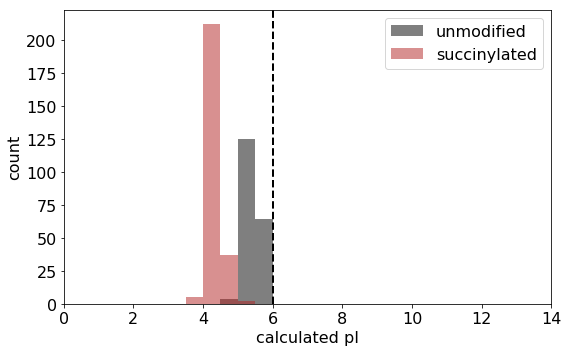

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
native_pi = []
succ_pi = []
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):  
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    # collect pIs of all sequences even if reaction is skipped elsewhere
    if rs.skip_rxn is True and rs.UniprotID != '' and rs.UniprotID != None:
        try:
            pI = rs.pI
        except AttributeError:
            print('calculating pI')
            IDs = rs.UniprotID.split(" ")
            total_sequence = ''
            for i in IDs:
                sequence = Uniprot_IO.get_sequence(i)
                total_sequence += sequence
            rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
            rs.save_object(output_dir+rs.pkl)
    
    if rs.UniprotID != '' and rs.UniprotID != None:
        if rs.req_mod == None:
            native_pi.append(rs.pI)
        else:
            succ_pi.append(rs.pI)
        
ax.hist(native_pi,
        facecolor='k',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='unmodified')

ax.hist(succ_pi,
        facecolor='firebrick',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='succinylated')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('calculated pI', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 14)
# plot pI cut-off
ax.axvline(x=param_dict['cutoff_pi'], c='k', lw='2', linestyle='--')
# legend
ax.legend(fontsize=16)

fig.tight_layout()
fig.savefig(output_dir+"pI_dist.pdf",
            dpi=720, bbox_inches='tight')

### Plot pI vs maximum component size

In [23]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


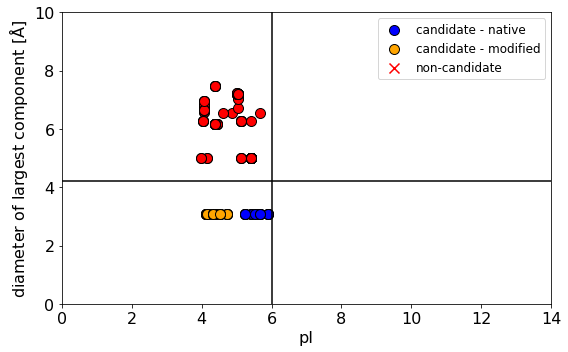

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
        
    if rs.seed_MOF is None:
        continue
    
    if rs.all_fit is True and rs.seed_MOF is True:
        M = 'o'
        if rs.req_mod is not None:
            C = 'orange'
        else:
            C = 'b'
        E = 'k'
    else:
        #if rs.pI < 6 or rs.max_comp_size < 4.2:
        #    print(rs.seed_MOF, rs.all_fit, rs.pkl, rs.pI, rs.max_comp_size)
        #    input('done')
        M = 'o'
        C = 'r'
        E = 'k'
        
    ax.scatter(rs.pI,
               rs.max_comp_size, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E,
           marker='o', 
           alpha=1.0,
           s=100,
           label='candidate - native')
ax.scatter(-100, 100,
           c='orange',
           edgecolors=E,
           marker='o',
           alpha=1,
           s=100,
           label='candidate - modified')
ax.scatter(-100, 100,
           c='r',
           edgecolors=E,
           marker='x',
           alpha=1,
           s=100,
           label='non-candidate')

ax.legend(loc=1, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=param_dict['cutoff_pi'], c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='pI',
                      ytitle='diameter of largest component [$\mathrm{\AA}$]',
                      xlim=(0, 14),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_pI.pdf", dpi=720,
            bbox_inches='tight')

### Plot # of reactions vs threshold value

In [25]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


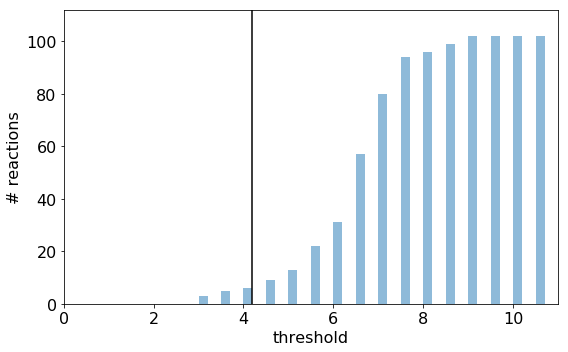

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
max_sizes = []
reaction_reported = [] 
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    try:
        if rs.max_comp_size > 0:
            max_sizes.append(rs.max_comp_size)
    except AttributeError:
        pass

    
max_sizes = np.asarray(max_sizes)
counts = []
threshs = np.arange(0.1, 21, 0.5)
for thr in threshs:
    count_above = len(max_sizes[max_sizes < thr])
    counts.append(count_above)
    
ax.bar(threshs, counts, align='center', alpha=0.5, width=0.2)

ax.axvline(x=threshold, c='k')

define_plot_variables(ax,
                      title='',
                      xtitle='threshold',
                      ytitle='# reactions',
                      xlim=(0, 11),
                      ylim=(0, max(counts)+10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_threshold.pdf", dpi=720,
            bbox_inches='tight')

### Categorize all molecules in output file

In [27]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])

In [28]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

unique molecule that fits: H2O - DB: SABIO - ID: 40.0
unique molecule that fits: O2 - DB: SABIO - ID: 1264.0
unique molecule that fits: H2O2 - DB: SABIO - ID: 1909.0
unique molecule that fits: NH3 - DB: SABIO - ID: 1268.0
unique molecule that fits: CO2 - DB: SABIO - ID: 1266.0
unique molecule that fits: methanol - DB: BRENDA - ID: 17790.0
unique molecule that fits: formaldehyde - DB: BKMS - ID: 16842.0
unique molecule that fits: Ca2+ - DB: SABIO - ID: 1289.0
unique molecule that fits: CN- - DB: SABIO - ID: 2269.0
unique molecule that fits: dioxygen - DB: BKMS - ID: 15379.0
unique molecule that fits: thiocyanate - DB: BRENDA - ID: 18022.0
unique molecule that fits: chloride - DB: BRENDA - ID: 17996.0
unique molecule that fits: hypochlorous acid - DB: BRENDA - ID: 24757.0
unique molecule that fits: superoxide - DB: BKMS - ID: 18421.0
unique molecule that fits: hydron - DB: BKMS - ID: 15378.0
unique molecule that fits: bromide - DB: BKMS - ID: 15858.0
unique molecule that fits: hypobromou

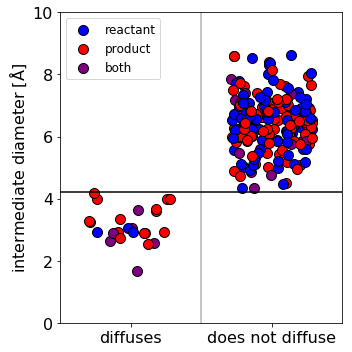

In [29]:
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in molecule_output.iterrows():
    mid_diam = row['mid_diam']
    if mid_diam == 0:
        continue
    if mid_diam <= threshold:
        M = 'o'
        E = 'k'
        D = 0.25
        print('unique molecule that fits:', row['name'], 
              '- DB:', row['DB'], '- ID:', row['DB_ID'])
    else:
        M = 'o'
        E = 'k'
        D = 0.75
    
    # set colour based on role
    if row['role'] == 'reactant':
        C = 'b'
    elif row['role'] == 'product':
        C = 'r'
    elif row['role'] == 'both':
        C = 'purple'
    
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='reactant')
ax.scatter(-100, 100,
           c='r', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='product')
ax.scatter(-100, 100,
           c='purple', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='both')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=0.5, c='k', alpha=0.3)
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

In [30]:
molecule_output

,name,iupac_name,DB,DB_ID,SMILE,role,min_diam,mid_diam,max_diam,ratio_1,ratio_2
0,H2O,oxidane,SABIO,40.0,O,both,2.492,2.586,3.748,0.347,0.653
1,O2,Molecular oxygen,SABIO,1264.0,[O],both,2.635,2.639,2.675,0.000,0.000
2,H2O2,hydrogen peroxide,SABIO,1909.0,OO,both,2.767,3.070,4.138,0.101,0.984
3,NH3,azanide,SABIO,1268.0,N,product,2.702,2.928,3.475,0.636,0.636
4,Urea,UREA,SABIO,1798.0,N=C(N)O,reactant,2.908,5.012,5.671,0.446,0.554
5,CO2,carbon dioxide,SABIO,1266.0,O=C=O,product,2.757,2.898,5.388,0.000,1.000
6,sucrose,"(2R,3R,4S,5S,6R)-2-[(2S,3S,4S,5R)-3,4-dihydrox...",KEGG,17992.0,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,reactant,0.000,0.000,0.000,0.000,0.000
7,beta-D-fructofuranose,"(2R,3S,4S,5R)-2,5-bis(hydroxymethyl)oxolane-2,...",KEGG,28645.0,O[CH2:1][C@@:2]1(O)O[C@H:5]([CH2:6]O)[C@@H:4](...,product,5.364,7.017,8.523,0.498,0.682
8,alpha-D-glucose,"6-(hydroxymethyl)oxane-2,3,4,5-tetrol",KEGG,17925.0,O[C@H:1]1O[C@H:5]([CH2:6]O)[C@@H:4](O)[C@H:3](...,both,4.862,7.193,8.328,0.444,0.734
9,raffinose,"(2R,3R,4S,5S,6R)-2-[(2S,3S,4S,5R)-3,4-dihydrox...",BKMS,16634.0,OC[C@H]1O[C@@](CO)(O[C@H]2O[C@H](CO[C@H]3O[C@H...,both,0.000,0.000,0.000,0.000,0.000


### print all reactions that fit

In [31]:
reaction_reported = []
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    if rs.all_fit is True:
        count += 1
        print("New Reaction:")
        rs.print_rxn_system()
        
print("There are", count, "new reactions!")

New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: BKMS
Database ID: 8219
-----------------------------------
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
methanol  (ID: 17790) as reactant
SMILES: CO
formaldehyde  (ID: 16842) as product
SMILES: C=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.7
Database: BRENDA
Database ID: BR59
-----------------------------------
chloride  (ID: 17996) as reactant
SMILES: [Cl-]
hydrogen peroxide  (ID: 16240) as

## Timing Information

#### pI screening - all sequences in BRENDA

(0, 30000)

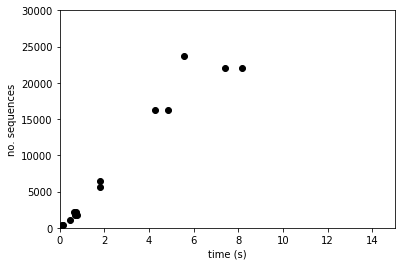

In [32]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

#### molecule screening

In [34]:
print('time taken to do molecule screening:')
print('collect reaction systems:', 1*60*60 + 47*60 + 34, 's')
print('accessibility:', 1*60*60 + 0*60 + 49, 's')
print('pI analysis:', 0*60*60 + 7*60 + 55, 's')
print('total:', 2*60*60 + 54*60 + 34 + 49 + 55, 's')

time taken to do molecule screening:
collect reaction systems: 6454 s
accessibility: 3649 s
pI analysis: 475 s
total: 10578 s
